# NLTK-vs-LLM-Sentiment-Analysis

Please use the below to set up your env to run the code, the requirements.txt ensures that you have the correct versions install and the import will ensure that you can run the code. 

In [38]:
#%pip freeze > dev_requirements.txt 

In [39]:
# Uncomment this line to install requirements
# !pip install -r requirements.txt

In [40]:
# Import necessary libraries

import os
import time
from time import sleep

import re

import logging
import requests
import pandas as pd
import numpy as np
import json
import spacy

import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import matplotlib.pyplot as plt

from openai import OpenAI, APIConnectionError
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from random import randint
from collections import Counter

from math import ceil
from dotenv import load_dotenv

In [ ]:
# Download the VADER sentiment analysis lexicon for sentiment analysis tasks
nltk.download('vader_lexicon')

# Download the NLTK stopwords list for filtering out common words in text processing
nltk.download('stopwords')

# Download the en_core_web_sm
!python -m spacy download en_core_web_sm

# Load the small English language model for spaCy, used for named entity recognition
nlp = spacy.load("en_core_web_sm")

In [42]:
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)


## Code Evolution Overview
The following process outlines the journey of refining the initial code into its final version. Moving forward, this document will focus exclusively on presenting the most recent and optimised version of the code

### Step 1 - Initial ingestion
This is the initial ingestion code used to pull the first page to ensure that the code works as epected. 

In [ ]:
# Base URL for the reviews
base_url = 'https://uk.trustpilot.com/review/www.directline.com'
    
# use request.get to pull data from the url
response = requests.get(base_url)

# Create a BeautifulSoup object
Response_text = BeautifulSoup(response.text, 'html.parser')

# show the response from BeautifulSoup
print(Response_text)

### Step 2 - Enable the selection of required data 
We now look to pull out the required data from the response. 

In [44]:
# set up blank dataframes. 
titles = []
texts = []

# Base URL for the reviews
base_url = 'https://uk.trustpilot.com/review/www.directline.com'
    

response = requests.get(base_url )

# Create a BeautifulSoup object
Response_text = BeautifulSoup(response.text, 'html.parser')

# Find all review containers on the page
reviews = Response_text.find_all('div', class_='styles_reviewContent__0Q2Tg')

# Extracting the review titles and texts
for review in reviews:
    title = review.find('h2', class_='typography_heading-s__f7029 typography_appearance-default__AAY17')
    text = review.find('p', class_='typography_body-l__KUYFJ typography_appearance-default__AAY17 typography_color-black__5LYEn')
    
    if title and text:  # Check if both elements were found
        titles.append(title.text.strip())
        texts.append(text.text.strip())

# Convert to pd Dataframe
df_1 = pd.DataFrame({
    'Title': titles,
    'Review': texts
})

df_1.head(5)



,Title,Review
0,Will never use another company!,Fantastic company. I renewed with DL in 2024 d...
1,My claim was dealt with quickly and efficently,My claim was dealt with quickly and my car wen...
2,Treated fairly I have,I have confidence that I will be treated fairl...
3,Superb company to deal with,Direct line made a stressful situation totally...
4,Been with direct line for many many…,Been with direct line for many many years. Alw...


### Step 3 - Addition of Loop.  
We will now look to loop through the web pages to pull through more reviews. 

In [45]:
# set up blank dataframes. 
titles = []
texts = []

# Base URL for the reviews
base_url = 'https://uk.trustpilot.com/review/www.directline.com?page='

# Loop through the desired number of pages
for page in range(1, 5 + 1): 
    # Pull the content of the page
    response = requests.get(base_url + str(page))
    
    # Create a BeautifulSoup object
    Response_text = BeautifulSoup(response.text, 'html.parser')
    
    # Find all review sections on the page
    reviews = Response_text.find_all('div', class_='styles_reviewContent__0Q2Tg')
    
    # Extracting the review titles and text
    for review in reviews:
        title = review.find('h2', class_='typography_heading-s__f7029 typography_appearance-default__AAY17')
        text = review.find('p', class_='typography_body-l__KUYFJ typography_appearance-default__AAY17 typography_color-black__5LYEn')
        
        # Check if both elements were found
        if title and text:  
            titles.append(title.text.strip())
            texts.append(text.text.strip())

# Create a DataFrame
df_2 = pd.DataFrame({
    'Title': titles,
    'Review': texts
})
df_2.head(5)

,Title,Review
0,Will never use another company!,Fantastic company. I renewed with DL in 2024 d...
1,My claim was dealt with quickly and efficently,My claim was dealt with quickly and my car wen...
2,Treated fairly I have,I have confidence that I will be treated fairl...
3,Superb company to deal with,Direct line made a stressful situation totally...
4,Been with direct line for many many…,Been with direct line for many many years. Alw...


### Step 4 - Code review

After code review it was advice to move this into a function and to use a more Pythonic way of doing things, this included adding error handeling for the response from the website and a random int to ensure we do not over load the website. This update was complated with the assistance of an Large Language Model (LLM) (https://chatgpt.com/) to add additional error handeling and code comments.  Here is the updated code:

In [46]:
def fetch_reviews(base_url: str, pages: int = 5, retries: int = 3) -> pd.DataFrame:
    """
    Fetch reviews from Trustpilot

    Args:
    - base_url (str): The base URL for the reviews.
    - pages (int): The number of pages to fetch reviews from. Defaults to 5. 
    - retries (int): The number of retries for failed requests. Defaults to 3.

    Returns:
    - pd.DataFrame: A DataFrame containing the review titles and texts.
    """

    # set up blank dataframes. 
    titles = []
    texts = []

    # Loop through the desired number of pages
    for page in range(1, pages + 1):
        attempt = 0
        while attempt < retries:
            try:
                 # Fetch the content of the page
                response = requests.get(f"{base_url}{page}")
                response.raise_for_status()

                # Create a BeautifulSoup object
                Response_text = BeautifulSoup(response.text, 'html.parser')

                # Find all review sections on the page
                reviews = Response_text.find_all('div', class_='styles_reviewContent__0Q2Tg')

                # If no reviews are found, log it but continue the process
                if not reviews:
                    print(f"No reviews found on page {page}.")
                    break

                # Iterate over each review
                for review in reviews:
                    try:
                        # Extract the review title and text
                        title = review.find('h2', class_='typography_heading-s__f7029 typography_appearance-default__AAY17')
                        text = review.find('p', class_='typography_body-l__KUYFJ typography_appearance-default__AAY17 typography_color-black__5LYEn')

                        # Check if both title and text are found
                        if title and text:
                            # Append the title and text to the lists
                            titles.append(title.text.strip())
                            texts.append(text.text.strip())
                    except AttributeError as e:
                        # Log the error and skip this review if extraction fails
                        print(f"Failed to extract review content on page {page}: {e}")
                        continue

                # If successful, break out of retry loop
                break

            except requests.exceptions.RequestException as e:
                # Log the error and retry if the maximum attempts are reached
                print(f"Failed to fetch reviews for page {page} (Attempt {attempt + 1}/{retries}): {e}")
                attempt += 1
                if attempt == retries:
                    print(f"Max retries reached for page {page}. Skipping to next page.")
                else:
                    # Sleep between retries to avoid hitting the server too hard
                    time.sleep(randint(3, 5))
            except Exception as e:
                # Log the unexpected error and exit the loop to avoid further issues
                print(f"An unexpected error occurred on page {page}: {e}")
                break

        # Sleep between retries to avoid hitting the server too hard
        time.sleep(randint(1, 3)) 
    print("Data Ingestion Complete")
    # Return a DataFrame containing the review titles and texts
    return pd.DataFrame({
        'Title': titles,
        'Review': texts})


In [47]:
# Set up the base URL and fetch data
base_url = 'https://uk.trustpilot.com/review/www.directline.com?page='
pages = 10
df_3 = fetch_reviews(base_url,pages)

Data Ingestion Complete


In [48]:
df_3.head(5)

,Title,Review
0,Will never use another company!,Fantastic company. I renewed with DL in 2024 d...
1,My claim was dealt with quickly and efficently,My claim was dealt with quickly and my car wen...
2,Treated fairly I have,I have confidence that I will be treated fairl...
3,Superb company to deal with,Direct line made a stressful situation totally...
4,Been with direct line for many many…,Been with direct line for many many years. Alw...


Showcases the difference in volume taken at each iteration of the code.
* df_1 representing the initial code which could onlt scrape data forom the 1st page.
* df_2 been once the loop was introduces and a manual cap of 5 pages added to the code 
* df_3 being the production code which takes in a veriable for the number of pages to scrape with the default if no variable is passes been 5. 

In [49]:
row_count_1 = len(df_1)
row_count_2 = len(df_2)
row_count_3 = len(df_3)
                  
comparison = pd.DataFrame({
    'DataFrame': ['df_1', 'df_2', 'df_3'],
    'Row Count': [row_count_1, row_count_2, row_count_3]
})

print(comparison)

  DataFrame  Row Count
0      df_1         20
1      df_2        100
2      df_3        183


----------------------------------------------------------------------------------------------------------------------
## Problem Statement - 

“Customer retention, particularly around renewals, is critical for sustained revenue and business growth. However, we have observed a decline in retention rates, which may indicate underlying customer dissatisfaction”.

## Data Ingestion 
1. Identify the data source: Public reviews from Trustpilot.
2. Fetch the data using web scraping (e.g., BeautifulSoup).
3. Store the data in a structured format (e.g., DataFrame using Pandas).

In [50]:
def fetch_reviews(base_url: str, pages: int = 5, retries: int = 3) -> pd.DataFrame:
    """
    Fetch reviews from Trustpilot

    Args:
    - base_url (str): The base URL for the reviews.
    - pages (int): The number of pages to fetch reviews from. Defaults to 5.
    - retries (int): The number of retries for failed requests. Defaults to 3.

    Returns:
    - pd.DataFrame: A DataFrame containing the review titles and texts.
    """

    # set up blank dataframes.
    titles = []
    texts = []

    # Loop through the desired number of pages
    for page in range(1, pages + 1):
        attempt = 0
        while attempt < retries:
            try:
                # Fetch the content of the page
                response = requests.get(f"{base_url}{page}")
                response.raise_for_status()

                # Create a BeautifulSoup object
                response_text = BeautifulSoup(response.text, 'html.parser')

                # Find all review sections on the page
                reviews = response_text.find_all('div', class_='styles_reviewContent__0Q2Tg')

                # If no reviews are found, log it but continue the process
                if not reviews:
                    logger.info(f"No reviews found on page {page}.")
                    break

                # Iterate over each review
                for review in reviews:
                    try:
                        # Extract the review title and text
                        title = review.find('h2', class_='typography_heading-s__f7029 typography_appearance-default__AAY17')
                        text = review.find('p', class_='typography_body-l__KUYFJ typography_appearance-default__AAY17 typography_color-black__5LYEn')

                        # Check if both title and text are found
                        if title and text:
                            # Append the title and text to the lists
                            titles.append(title.text.strip())
                            texts.append(text.text.strip())
                    except AttributeError as e:
                        # Log the error and skip this review if extraction fails
                        logger.warning(f"Failed to extract review content on page {page}: {e}")
                        continue

                # If successful, break out of retry loop
                break

            except requests.exceptions.RequestException as e:
                # Log the error and retry if the maximum attempts are reached
                logger.error(f"Failed to fetch reviews for page {page} (Attempt {attempt + 1}/{retries}): {e}")
                attempt += 1
                if attempt == retries:
                    logger.error(f"Max retries reached for page {page}. Skipping to next page.")
                else:
                    # Sleep between retries to avoid hitting the server too hard
                    time.sleep(randint(3, 5))
            except BaseException as e: 
                # Log the unexpected error and exit the loop to avoid further issues
                logger.critical(f"An unexpected error occurred on page {page}: {e}")
                break

        # Sleep between retries to avoid hitting the server too hard
        time.sleep(randint(1, 3))

    # Return a DataFrame containing the review titles and texts
    logger.info(f"Total reviews collected: {len(titles)}")
    return pd.DataFrame({
        'Title': titles,
        'Reviews': texts})

## Data Processing
1. Anonymise the data using named entity recognition (NER) to replace sensitive information with placeholders.
2. Remove duplicate entries and irrelevant data, ensuring a clean dataset.
3. Standardise text formats by converting to lowercase and removing unnecessary spaces.


In [51]:
def clean_text(text: str) -> str:
    """
    Clean and preprocess text data by performing the following steps:
    1. Remove non-word characters (e.g., punctuation and special symbols).
    2. Convert text to lowercase for uniformity.
    3. Anonymise named entities such as PERSON, ORG, GPE, LOC, and DATE 
       by replacing them with their corresponding entity labels.

    Args:
        text (str): The input text to be cleaned and anonymised.

    Returns:
        str: The processed text with non-word characters removed, 
             text standardised to lowercase, and sensitive entities anonymised.
    """
    try:
        # Process text with spaCy to identify named entities
        doc = nlp(text)

        # Replace named entities with placeholders
        for ent in doc.ents:
            if ent.label_ in {"PERSON", "ORG", "GPE"}: 
                text = text.replace(ent.text, f"[{ent.label_}]")
        
        # Remove non-word characters and convert to lowercase
        text = re.sub(r'[^\w\s]', '', text)
        text = text.lower()
        
        return text

    except BaseException as e:
        logger.error(f"An error occurred while cleaning text: {e}")
        raise

## Exploratory Data Analysis (EDA)
1. Identify frequently occurring words
2. Add industry/company relevent words to the 'stop_words' list to remove from analysis

In [52]:
def plot_most_common_words(df: pd.DataFrame, stop_words: set) -> None:
    """
    Visualise the most common words in the complaint notes as a bar chart.

    Args:
        df (pd.DataFrame): The DataFrame containing a 'cleaned_notes' column with preprocessed text.
        stop_words (set): A set of common words to exclude from the analysis.

    Returns:
        None
    """
    try:
        # Check if the DataFrame contains the required column
        if 'cleaned_notes' not in df.columns:
            raise ValueError("The following required column is missing from the DataFrame: 'cleaned_notes'")
        
        # Combine all cleaned notes into a single string
        all_notes = " ".join(df['cleaned_notes'])

        # Split the string into individual words and count their frequencies
        word_counts = Counter(word for word in all_notes.split() if word not in stop_words)

        # Get the 10 most common words
        common_words = word_counts.most_common(10)
        if not common_words:
            logger.warning("No words were found after excluding stop words.")
            return

        # Plot the most common words
        words, counts = zip(*common_words)
        plt.figure(figsize=(10, 6))
        plt.bar(words, counts)
        plt.title('Most Common Words in Complaint Notes')
        plt.xlabel('Words')
        plt.ylabel('Frequency')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        logger.info("Bar chart successfully plotted.")
    except ValueError as ve:
        logger.error(f"ValueError encountered: {ve}")
        raise
    except BaseException as e:
        logger.critical(f"An unexpected error occurred: {e}")
        raise


In [53]:
def plot_common_bigrams(df: pd.DataFrame, stop_words: set, top_n: int = 10) -> None:
    """
    Plot the top 'n' bigrams in complaint notes as a bar chart.

    Args:
        df (pd.DataFrame): The DataFrame containing the complaint notes.
        stop_words (set): A set of common words to exclude from the analysis.

    Returns:
        None: Displays a bar chart of the most common bigrams.
    """
    try:
        # Check to see if the input DataFrame contains required column.
        if 'cleaned_notes' not in df.columns:
            logger.error("The following required columns are missing from the DataFrame:'cleaned_notes'")
            raise ValueError("The following required columns are missing from the DataFrame:'cleaned_notes'")

        # Extract two-word phrases from the text data using ngram_range.
        vectorizer = CountVectorizer(stop_words=list(stop_words), ngram_range=(2, 2))

        # Fit the vectorizer to the text data and transform it into a matrix of token counts.
        X = vectorizer.fit_transform(df['cleaned_notes'])

        # Get the bigram counts from the matrix.
        bigram_counts = dict(zip(vectorizer.get_feature_names_out(), X.toarray().sum(axis=0)))

        # Get the 10 most common bigrams.
        common_bigrams = sorted(bigram_counts.items(), key=lambda x: x[1], reverse=True)[:top_n]

        # Plot the most common bigrams.
        bigrams, counts = zip(*common_bigrams)
        plt.figure(figsize=(10, 6)) 
        plt.bar(bigrams, counts)
        plt.title(f'Top {top_n} Bigrams in Complaint Notes')
        plt.xlabel('Bigrams')
        plt.ylabel('Frequency')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        logger.info("Bigrams successfully created.")
    except ValueError as ve:
        logger.error(f"ValueError encountered: {ve}")
        raise
    except BaseException as e:
        logger.critical(f"An unexpected error occurred: {e}")
        raise

## Sentiment Analysis
Use pre-built sentiment analysis tools (e.g., NLTK's VADER).
Classify reviews into positive, negative, or neutral categories.
Perform custom sentiment analysis if needed for tailored results.

In [54]:
def get_sentiment(cleaned_notes: str) -> dict:
    """
    Get sentiment polarity scores for the given text using the VADER sentiment analysis tool.

    Args:
        cleaned_notes (str): The text to be analysed.

    Returns:
        dict: A dictionary containing the sentiment polarity scores.
    """
    # Check to see if the input DataFrame contains required column.
    if 'cleaned_notes' not in df.columns:
        raise ValueError("The following required columns are missing from the DataFrame:'cleaned_notes'")
    
    # Ensure the input is a string
    if not isinstance(cleaned_notes, str):
        cleaned_notes = str(cleaned_notes) if cleaned_notes is not None else ""

    try:
        # Perform sentiment analysis
        return sia.polarity_scores(cleaned_notes)
    except Exception as e:
        logger.critical(f"Error analysing sentiment for text: {cleaned_notes}")
        raise 

In [55]:
def sentiment_classification(row: pd.Series, pos_threshold: float = 0.15, neg_threshold: float = 0.15) -> str:
    """
    Classify sentiment with enhanced thresholds for better handling of mixed sentiments.

    Args:
        row (pd.Series): A pandas Series containing the sentiment scores.
        pos_threshold (float, optional): The threshold for dominant positive sentiment. Defaults to 0.15.
        neg_threshold (float, optional): The threshold for dominant negative sentiment. Defaults to 0.15.

    Returns:
        str: The classified sentiment ('Positive', 'Negative', or 'Neutral').
    """
    # Check for dominant positive sentiment
    if row['Text_Positive'] - row['Text_Negative'] > pos_threshold:
        return 'Positive'

    # Check for dominant negative sentiment
    elif row['Text_Negative'] - row['Text_Positive'] > neg_threshold:
        return 'Negative'

    # Handle neutral or mixed sentiments
    elif row['Text_Neutral'] > max(row['Text_Positive'], row['Text_Negative']):
        return 'Neutral'

    # Default to neutral if no other conditions are met
    else:
        return 'Neutral'

In [56]:
def sentiment_analysis(df: pd.DataFrame, pos_threshold: float, neg_threshold: float) -> pd.DataFrame:
    """
    Perform sentiment analysis on titles and texts.

    Args:
        df (pd.DataFrame): The DataFrame containing the text data.
        pos_threshold (float): Specifies the positive sentiment threshold. Default is 0.15.
        neg_threshold (float): Specifies the negative sentiment threshold. Default is 0.15.

    Returns:
        pd.DataFrame: The DataFrame with sentiment analysis results.
    """
    # Check to see if the input DataFrame contains required column.
    try:
        if 'cleaned_notes' not in df.columns:
            raise ValueError("The following required columns are missing from the DataFrame:'cleaned_notes'")
        
        # Apply sentiment analysis to titles and texts and store results in separate columns
        df['Title_Sentiment'] = df['Title'].apply(get_sentiment)
        df['Text_Sentiment'] = df['cleaned_notes'].apply(get_sentiment)

        # Separate sentiment scores into separate columns for better readability
        df['Title_Positive'] = df['Title_Sentiment'].apply(lambda x: x['pos'])
        df['Title_Negative'] = df['Title_Sentiment'].apply(lambda x: x['neg'])
        df['Title_Neutral'] = df['Title_Sentiment'].apply(lambda x: x['neu'])

        df['Text_Positive'] = df['Text_Sentiment'].apply(lambda x: x['pos'])
        df['Text_Negative'] = df['Text_Sentiment'].apply(lambda x: x['neg'])
        df['Text_Neutral'] = df['Text_Sentiment'].apply(lambda x: x['neu'])

        # Apply custom sentiment analysis to the sentiment score columns
        df['Title_Sentiment'] = df.apply(lambda row: sentiment_classification(row, pos_threshold, neg_threshold), axis=1)
        df['Text_Sentiment'] = df.apply(lambda row: sentiment_classification(row, pos_threshold, neg_threshold), axis=1)
        
        # Sentiment classification for overall sentiment based on both Title and Text Sentiment
        df['Sentiment_Classification'] = df.apply(lambda row: sentiment_classification(row, pos_threshold, neg_threshold), axis=1)

        logger.info("Sentiment analysis complete.")
        return df
    except ValueError as ve:
        logger.error(f"ValueError encountered: {ve}")
        raise
    except BaseException as e:
        logger.critical(f"An unexpected error occurred: {e}")
        raise


## Visualisation
Generate word clouds for common keywords.
Create bar charts and pie charts to display sentiment distributions.
Plot bigrams or trigrams for deeper insights.

In [57]:
def generate_word_cloud(df: pd.DataFrame, num_words: int = 10, sentiment_filter: str =  None, Sentiment_column: str = "cleaned_notes") -> None:
    """
    Generate a word cloud from the Reviewst data. Optional to filter by sentiment.

    Args:
        df (pd.DataFrame): The DataFrame containing the Reviews data.
        num_words (int, optional): The number of words to display in the word cloud. Defaults to 10.
        sentiment_filter (str, optional): A sentiment filter (e.g., 'positive', 'negative') to filter the data.
        Sentiment_column (str, optional): The column name that contains the sentiment classification. Defaults to "cleaned_notes".

    Returns:
        None
    """
    try:
        # Check to see if the input DataFrame contains required column.
        if Sentiment_column not in df.columns:
            raise ValueError(f"The following required columns are missing from the DataFrame:{Sentiment_column}")
        
        # Filter the DataFrame if a sentiment filter is provided
        if sentiment_filter:
            df_filtered = df[df['Sentiment_Classification'].str.lower() == sentiment_filter.lower()]
        else:
            df_filtered = df
        
        # Check if filtered DataFrame is empty
        if df_filtered.empty:
            raise ValueError("No reviews match the specified sentiment filter.")

        # Combine all the cleaned notes into a single string
        cleaned_text = " ".join(
            word for word in " ".join(df_filtered[Sentiment_column]).split() if word.lower() not in stop_words
        )

        # Generate word frequencies
        wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=num_words).generate(cleaned_text)

        # Display the word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Word Cloud - {'Filtered: ' + sentiment_filter if sentiment_filter else 'All Reviews'}", fontsize=16)
        plt.tight_layout()
        plt.show()

        logger.info("Word cloud successfully created.")
    except ValueError as ve:
        logger.error(f"ValueError encountered: {ve}")
        raise
    except BaseException as e:
        logger.critical(f"An unexpected error occurred: {e}")
        raise



In [58]:
def plot_common_bigrams_with_sentiment(df: pd.DataFrame, stop_words: set, top_n: int = 10) -> None:
    """
    Plot the most common bigrams in the complaint notes and classify them based on the feedback sentiment.

    Args:
        df (pd.DataFrame): The DataFrame containing the complaint notes.
        stop_words (set): A set of common words to be excluded from the analysis.
        pos_threshold (float): Specifies the positive sentiment threshold. Default is 0.15.
        neg_threshold (float): Specifies the negative sentiment threshold. Default is 0.15.
        top_n (int): The number of most common bigrams to display. Default is 10.

    Returns:
        None
    """
    
    try:
        # Check to see if the input DataFrame contains required column.
        if 'cleaned_notes' not in df.columns:
            raise ValueError("The following required columns are missing from the DataFrame:'cleaned_notes'")


        # Vectorising to get bigrams
        vectorizer = CountVectorizer(stop_words=list(stop_words), ngram_range=(2, 2))
        X = vectorizer.fit_transform(df['cleaned_notes'])
        bigram_counts = dict(zip(vectorizer.get_feature_names_out(), X.toarray().sum(axis=0)))
        common_bigrams = sorted(bigram_counts.items(), key=lambda x: x[1], reverse=True)[:top_n]

        # Unpacking bigrams and their counts
        bigrams, counts = zip(*common_bigrams)

        # Classify bigrams based on the feedback sentiment
        bigram_sentiments = []
        for bigram in bigrams:
            feedback_sentiments = df[df['cleaned_notes'].str.contains(bigram, case=False, na=False)]['Sentiment_Classification']
            bigram_sentiments.append(feedback_sentiments.mode()[0] if not feedback_sentiments.empty else 'Neutral')

        # Plot the results
        fig, ax = plt.subplots(figsize=(10, 6))
        bars = ax.bar(bigrams, counts, color='lightblue')

        for i, bar in enumerate(bars):
            ax.annotate(bigram_sentiments[i],
                        xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')
            
        ax.set_xticks(range(len(bigrams)))
        # Set the title and labels
        ax.set_title(f'Top {len(bigrams)} Bigrams in Complaint Notes with SentimentClassification')
        ax.set_xlabel('Bigrams')
        ax.set_ylabel('Frequency')

        # Set the x-tick labels with rotation
        ax.set_xticklabels(bigrams, rotation=30, ha='right')

        # Adjust layout to ensure everything fits
        plt.tight_layout()

        # Show the plot
        plt.show()
    
        logger.info("Bigrams with sentiment successfully created.")
    except ValueError as ve:
        logger.error(f"ValueError encountered: {ve}")
        raise
    except BaseException as e:
        logger.critical(f"An unexpected error occurred: {e}")
        raise


In [59]:
def plot_average_sentiment_scores(df: pd.DataFrame) -> None:
    """
    Plot average sentiment scores for titles and texts.

    Args:
        df (pd.DataFrame): The DataFrame containing the sentiment scores.
    """
    try:
        # Check to see if the input DataFrame contains required column.
        required_columns = ['Title_Positive', 'Title_Negative', 'Title_Neutral',
                            'Text_Positive', 'Text_Negative', 'Text_Neutral']
        missing_columns = [col for col in required_columns if col not in df.columns]
        if missing_columns:
            raise ValueError(f"The following required columns are missing from the DataFrame: {missing_columns}")

        # Calculate average sentiment scores
        average_scores = {
            'Titles': {
                'Positive': df['Title_Positive'].mean(),
                'Negative': df['Title_Negative'].mean(),
                'Neutral': df['Title_Neutral'].mean()
            },
            'Reviews': {
                'Positive': df['Text_Positive'].mean(),
                'Negative': df['Text_Negative'].mean(),
                'Neutral': df['Text_Neutral'].mean()
            }
        }

        # Prepare data for plotting
        categories = list(average_scores['Titles'].keys())
        titles_scores = list(average_scores['Titles'].values())
        texts_scores = list(average_scores['Reviews'].values())

        # Create a bar plot
        fig, ax = plt.subplots(figsize=(10, 6))
        x = np.arange(len(categories))  # the label locations
        width = 0.35  # the width of the bars

        # Update colours to be more accessible for colour blindness
        ax.bar(x - width/2, titles_scores, width, label='Titles', color='#1f77b4')  # Blue
        ax.bar(x + width/2, texts_scores, width, label='Reviews', color='#ff7f0e')  # Orange

        # Add labels and title
        ax.set_ylabel('Average Sentiment Scores')
        ax.set_title('Average Sentiment Scores for Titles and Reviews')
        ax.set_xticks(x)
        ax.set_xticklabels(categories)
        ax.legend()

        # Add data labels
        def add_labels(bars):
            for bar in bars:
                height = bar.get_height()
                ax.annotate(f'{height:.2f}',
                            xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom')

        add_labels(ax.patches[:len(categories)])
        add_labels(ax.patches[len(categories):])

        plt.tight_layout() 
        plt.show()

        logger.info("Sentiment Score charts created")
    except ValueError as ve:
        logger.error(f"ValueError encountered: {ve}")
        raise
    except BaseException as e:
        logger.critical(f"An unexpected error occurred: {e}")
        raise

In [60]:
def plot_sentiment_distribution(df: pd.DataFrame) -> None:
    """
    Plot the distribution of sentiment classifications for Title, Reviews, and Overall Sentiment.

    Args:
        df (pd.DataFrame): The DataFrame containing the sentiment classifications.
    """
    try:
        # Check to see if the input DataFrame contains required column.
        required_columns = ['Title_Sentiment', 'Text_Sentiment']
        missing_columns = [col for col in required_columns if col not in df.columns]
        if missing_columns:
            raise ValueError(f"The following required columns are missing from the DataFrame: {missing_columns}")
        
        # Define the sentiment categories in the desired order
        sentiment_categories = ['positive', 'neutral', 'negative']

        # Define a colour palette
        colors = ['#1E90FF',  # Blue for Positive
                '#808080',  # Grey for Neutral
                '#ff7f0e']  # Orange for Negative

        # Create the figure
        plt.figure(figsize=(12, 6))

        # Plot Title Custom Sentiment Distribution
        title_sentiment_counts = df['Title_Sentiment'].str.lower().value_counts().reindex(sentiment_categories, fill_value=0)
        plt.subplot(1, 2, 1)
        plt.pie(title_sentiment_counts, labels=title_sentiment_counts.index, autopct='%1.1f%%', 
                startangle=140, colors=colors)
        plt.title('Title Custom Sentiment Distribution')

        # Plot Reviews Custom Sentiment Distribution
        Reviews_sentiment_counts = df['Text_Sentiment'].str.lower().value_counts().reindex(sentiment_categories, fill_value=0)
        plt.subplot(1, 2, 2)
        plt.pie(Reviews_sentiment_counts, labels=Reviews_sentiment_counts.index, autopct='%1.1f%%', 
                startangle=140, colors=colors)
        plt.title('Reviews Custom Sentiment Distribution')

        # Show the pie charts
        plt.tight_layout()
        plt.show()
        
        logger.info("Sentiment distribution plot created")
    except ValueError as ve:
        logger.error(f"ValueError encountered: {ve}")
        raise
    except BaseException as e:
        logger.critical(f"An unexpected error occurred: {e}")
        raise

In [61]:
def plot_sentiment_distribution_overall(df: pd.DataFrame, sentiment_column: str = None, title: str = 'Sentiment Distribution') -> None:
    """
    Plot the distribution of sentiment classifications for Overall Sentiment.

    Args:
        df (pd.DataFrame): The DataFrame containing the sentiment classifications.
        sentiment_column (str, optional): The column name for the overall sentiment classification. Defaults to None.
        title (str, optional): The title for the overall sentiment distribution plot. Defaults to 'Sentiment Distribution'.
    """
    try:
        # Check to see if the input DataFrame contains required column.
        if sentiment_column not in df.columns:
            raise ValueError(f"The following required columns are missing from the DataFrame:{sentiment_column}")

        # Define the sentiment categories in the desired order
        sentiment_categories = ['positive', 'neutral', 'negative']

        # Define a colour palette
        colors = ['#1E90FF',  # Blue for Positive
                '#808080',  # Grey for Neutral
                '#ff7f0e']  # Orange for Negative

        # Plot Overall Custom Sentiment Distribution
        overal_sentiment_counts = df[sentiment_column].str.lower().value_counts().reindex(sentiment_categories, fill_value=0)
        plt.figure(figsize=(6, 6))
        plt.pie(overal_sentiment_counts, labels=overal_sentiment_counts.index, autopct='%1.1f%%', 
                startangle=140, colors=colors)
        plt.title(title)

        # Show the pie charts
        plt.tight_layout()
        plt.show()

        logger.info("Oerall Sentiment distribution plot created")
    except ValueError as ve:
        logger.error(f"ValueError encountered: {ve}")
        raise
    except BaseException as e:
        logger.critical(f"An unexpected error occurred: {e}")
        raise

## Initial Set up and Review
In this stage, we will ingest the data and review the most common words within the customer reviews. This will help us identify additional words that are specific to our business and not part of the standard stopwords. These business-specific words can then be excluded to refine the analysis.

2025-01-03 14:53:00,134 - INFO - Total reviews collected: 183
2025-01-03 14:53:01,396 - INFO - All reviews successfully cleaned.


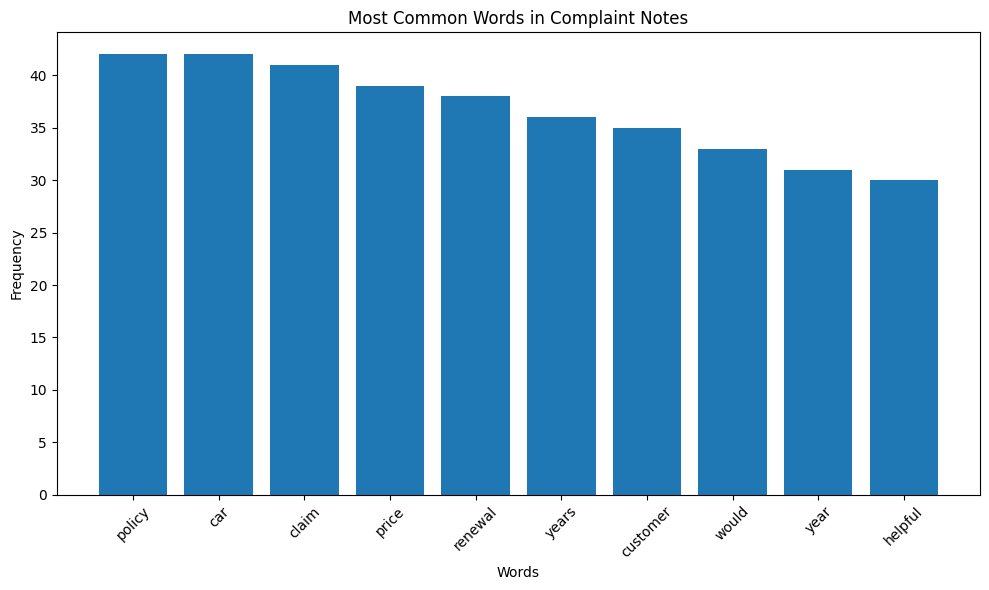

2025-01-03 14:53:01,535 - INFO - Bar chart successfully plotted.


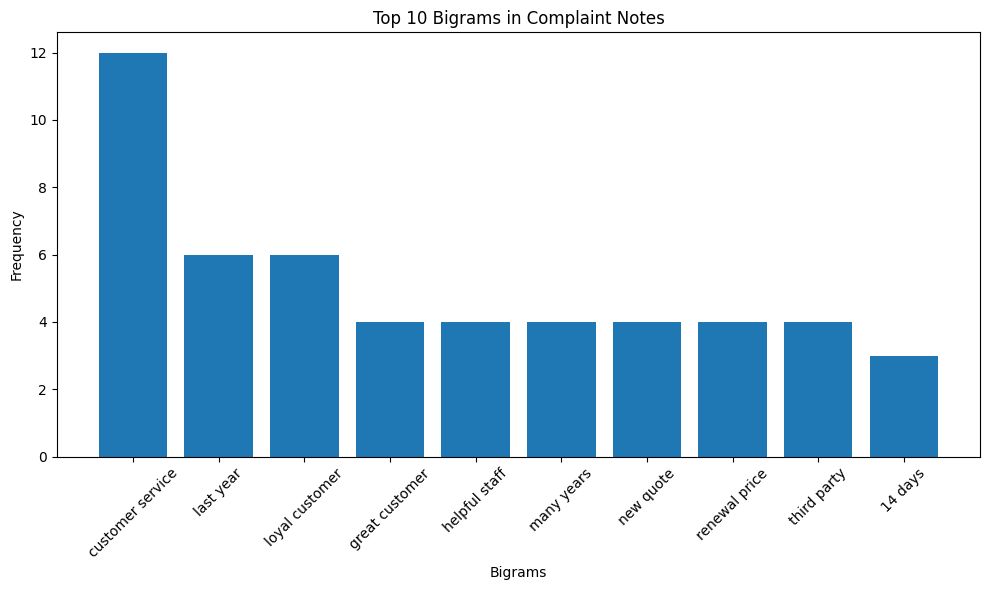

2025-01-03 14:53:01,638 - INFO - Bigrams successfully created.


In [62]:
# Set up the base URL and fetch data
base_url = 'https://uk.trustpilot.com/review/www.directline.com?page='
pages = 10
df = fetch_reviews(base_url,pages)

# add additional words to remove as required
stop_words = set(stopwords.words('english')).union({'direct', 'line', 'insurance', 'org', 'person', 'gpe'})

sia = SentimentIntensityAnalyzer()

# Data Preprocessing
df['cleaned_notes'] = df['Reviews'].apply(clean_text)
logger.info("All reviews successfully cleaned.")

# Exploratory Data Analysis
plot_most_common_words(df,stop_words)

# Define the number of bigrams to display
top_n = 10
plot_common_bigrams(df, stop_words, top_n)


## Data Visulisations After Sentiment Analysis
The follwoing code is used to producde visulisations after we have performed sentiment analysis on the data.

In [63]:
df.head()

,Title,Reviews,cleaned_notes
0,Will never use another company!,Fantastic company. I renewed with DL in 2024 d...,fantastic company i renewed with dl in 2024 du...
1,My claim was dealt with quickly and efficently,My claim was dealt with quickly and my car wen...,my claim was dealt with quickly and my car wen...
2,Treated fairly I have,I have confidence that I will be treated fairl...,i have confidence that i will be treated fairl...
3,Superb company to deal with,Direct line made a stressful situation totally...,direct line made a stressful situation totally...
4,Been with direct line for many many…,Been with direct line for many many years. Alw...,been with direct line for many many years alwa...


2025-01-03 14:53:01,723 - INFO - Sentiment analysis complete.


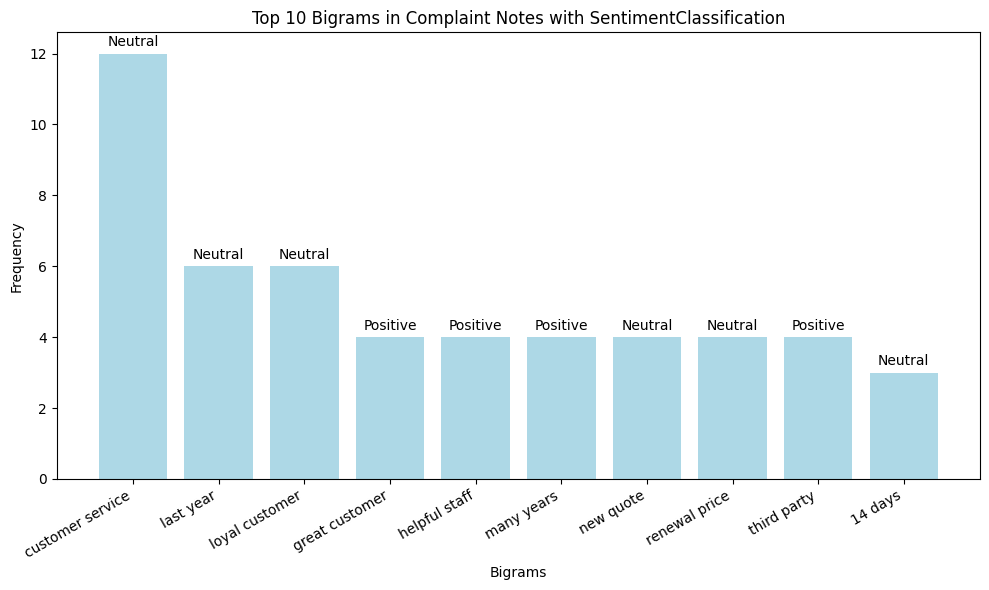

2025-01-03 14:53:01,856 - INFO - Bigrams with sentiment successfully created.


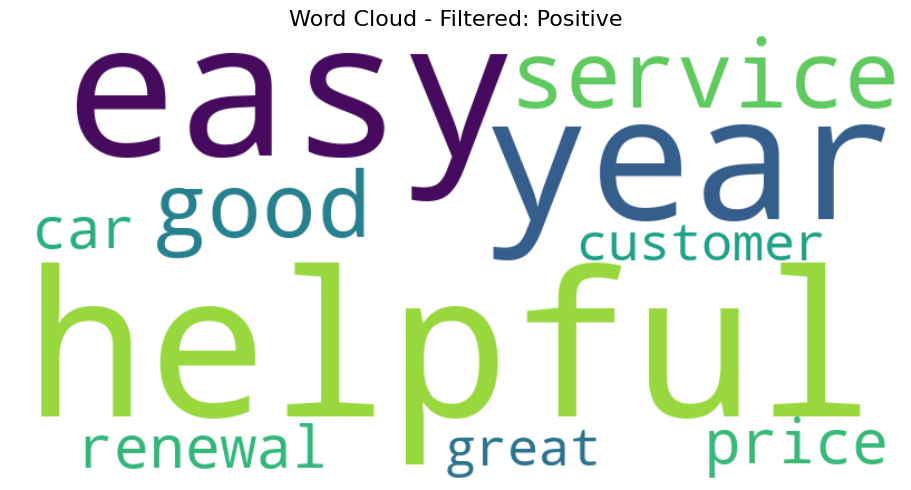

2025-01-03 14:53:02,096 - INFO - Word cloud successfully created.


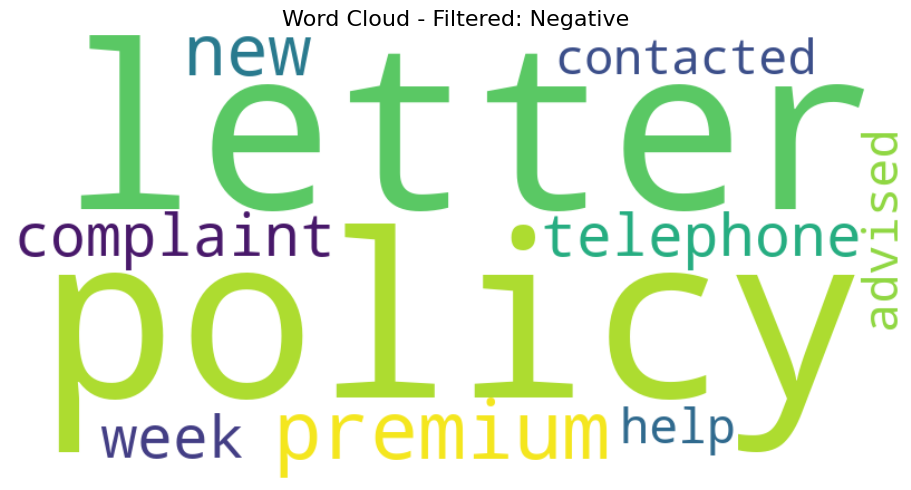

2025-01-03 14:53:02,343 - INFO - Word cloud successfully created.


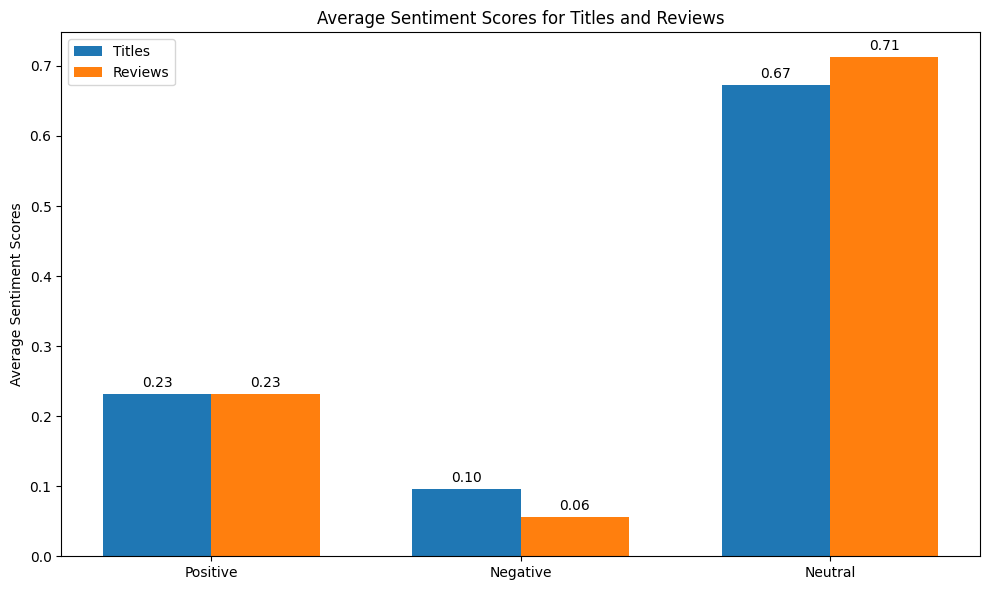

2025-01-03 14:53:02,457 - INFO - Sentiment Score charts created


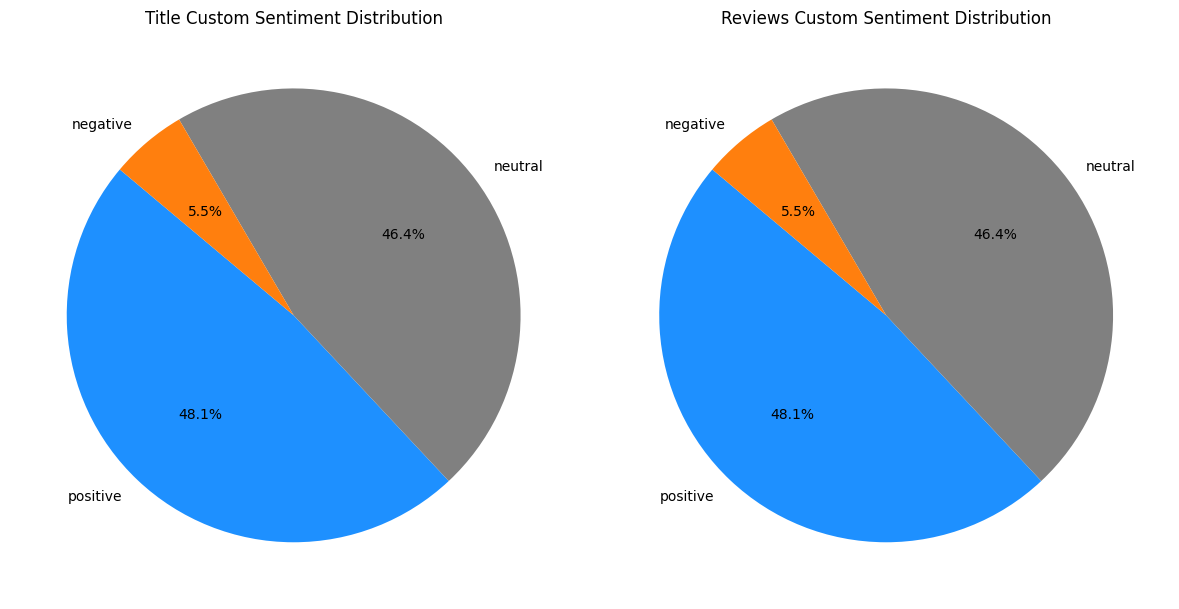

2025-01-03 14:53:02,535 - INFO - Sentiment distribution plot created


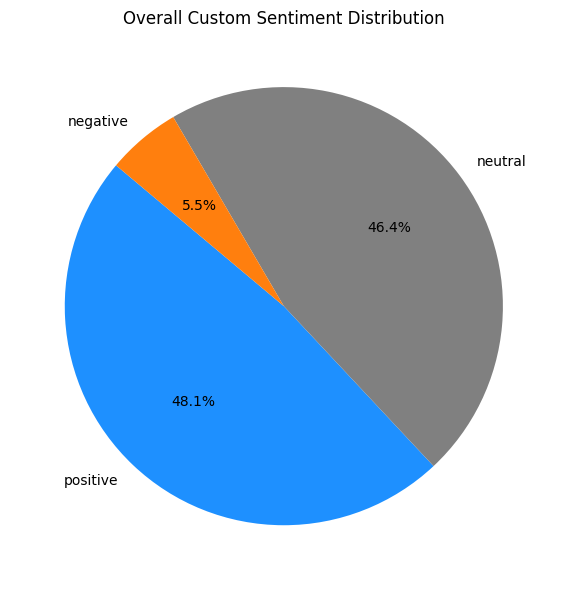

2025-01-03 14:53:02,576 - INFO - Oerall Sentiment distribution plot created


In [64]:
# The threshold for dominant sentiment values.
pos_threshold = 0.15
neg_threshold = 0.15

# Sentiment Analysis
df = sentiment_analysis(df, pos_threshold, neg_threshold)


# Plot Comment words with Sentiment
# Define the number of bigrams to display
top_n = 10
plot_common_bigrams_with_sentiment(df, stop_words, top_n)

# Generete wordcloud
generate_word_cloud(df, num_words=10, sentiment_filter='Positive')
generate_word_cloud(df, num_words=10, sentiment_filter='Negative')

# Plot Average Sentiment Scores
plot_average_sentiment_scores(df)

# Plot Sentiment Distribution
plot_sentiment_distribution(df)
plot_sentiment_distribution_overall(df, sentiment_column='Sentiment_Classification', title='Overall Custom Sentiment Distribution')

## Further Analysis on Nuteral
As shown above we still have a large amount of our data is classified as nuteral using the standard classification, we will now try to break this down more to provde even more analsysis. The first test is to add in additional key words to see if we can get a better classification. The use of an LLM's (https://chatgpt.com/ and https://gemini.google.com/) were used to generate the list of key words. 

In [65]:
keywords = {
    'Ambiguous': [
        # Uncertainty and Doubt
        'not sure', 'uncertain', 'maybe', 'possibly', 'perhaps', 
        'doubtful', 'unsure', 'vague', 'unclear', 'indecisive', 
        'iffy', 'hesitant', 'undecided', 'on the fence',
        
        # Complexity and Nuance
        'complicated', 'complex', 'hard to tell', 'it depends', 
        'not straightforward', 'multiple interpretations', 
        'open to interpretation', 'gray area', 'not black and white',
        
        # Linguistic Markers of Uncertainty
        'kind of', 'sort of', 'somewhat', 'relatively', 'fairly', 
        'more or less', 'to some extent', 'in a way'
    ],
    
    'Mixed Feelings': [
        # Emotional Complexity
        'mixed feelings', 'both good and bad', 'like and dislike', 
        'pros and cons', 'some things were good', 'conflicted', 
        'torn', 'ambivalent', 'bittersweet', 'love-hate', 
        'not all bad', 'had its moments', 'up and down', 
        'good and bad sides',
        
        # Nuanced Emotional States
        'complicated emotions', 'not straightforward', 
        'positive and negative', 'happy yet sad', 'pleased but disappointed', 
        'glad but frustrated', 'excited and worried', 
        'happy with reservations', 'pleased but not completely satisfied',
        
        # Contextual Qualifiers
        'it depends', 'context matters', 'situation-specific', 
        'depends on perspective', 'different angles', 'varied experience'
    ],
    
    'Balanced': [
        # Neutrality and Moderation
        'okay', 'decent', 'average', 'fine', 'acceptable', 
        'satisfactory', 'neutral', 'even-handed', 'reasonable', 
        'moderate', 'fair', 'all right', 'so-so', 'not bad', 
        'nothing special', 'middle of the road',
        
        # Equivalence and Equilibrium
        'balanced', 'equal', 'evenly matched', 'neither good nor bad', 
        'no strong feelings', 'middle ground', 'compromise', 
        'neither here nor there', 'status quo',
        
        # Measured Descriptions
        'adequate', 'sufficiently good', 'meets expectations', 
        'standard', 'typical', 'normal', 'par for the course', 
        'nothing extraordinary', 'run-of-the-mill'
    ]
}

In [66]:
def classify_neutral_review(text: str) -> str:
    """
    Classify a neutral review based on the presence and frequency of specific keywords.

    Args:
        text (str): The text of the review.

    Returns:
        str: The classification of the review.
    """

    try:
        # Confirm text is not empty or invalid
        if not isinstance(text, str) or text.strip() == "":
            return 'Unclassified'

        # Convert the text to lowercase for case-insensitive matching
        text_lower = text.lower()

        # Initialise a dictionary to store the scores for each category
        category_scores = {category: 0 for category in keywords.keys()}

        # Scoring mechanism
        for category, words in keywords.items():
            for word in words:
                # Count occurrences of each keyword
                word_count = text_lower.count(word)
                if word_count > 0:
                    # Weighted scoring to account for multiple matches
                    category_scores[category] += word_count

        # Advanced classification logic
        def get_top_categories() -> list:
            """
            Get the top categories with non-zero scores.

            Returns:
                list: A list of tuples containing the category and its score.
            """
            # Filter out categories with zero score
            scored_categories = {k: v for k, v in category_scores.items() if v > 0}

            if not scored_categories:
                return []

            # Sort categories by score in descending order
            sorted_categories = sorted(scored_categories.items(), key=lambda x: x[1], reverse=True)
            return sorted_categories

        top_categories = get_top_categories()

        # Detailed classification logic
        if not top_categories:
            return 'Unclassified'

        # Prioritisation hierarchy
        priority_order = [
            'Balanced', 
            'Mixed Feelings', 
            'Ambiguous'
    ]

        # First, check for exact match in priority order
        for category in priority_order:
            if any(cat == category for cat, _ in top_categories):
                return category

        # If no exact match, return the top-scored category
        return top_categories[0][0]


    except ValueError as ve:
        logger.error(f"ValueError encountered: {ve}")
        raise
    except BaseException as e:
        logger.critical(f"An unexpected error occurred: {e}")
        raise

In [67]:
def process_reviews_for_classification(df: pd.DataFrame) -> pd.DataFrame:
    """
    Apply the classify_neutral_review function to each review in the DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing the reviews.
        review_column (str): The column containing the review text to classify.

    Returns:
        pd.DataFrame: The DataFrame with an additional column for the classification result.
    """

    try:
        # Check to see if the input DataFrame contains required column.
        if 'cleaned_notes' not in df.columns:
            raise ValueError("The following required columns are missing from the DataFrame:'cleaned_notes'")

        # Apply the classification function to each review
        df['Review_Classification'] = df['cleaned_notes'].apply(classify_neutral_review)
        logger.info("classify nuteral reviews completed")
        return df
    
    except ValueError as ve:
        logger.error(f"ValueError encountered: {ve}")
        raise
    except BaseException as e:
        logger.critical(f"An unexpected error occurred: {e}")
        raise

In [68]:
def plot_neutral_classification_distribution(df: pd.DataFrame, column_name: str ='Review_Classification')-> None:
    """
    Plots the distribution of neutral classifications as a bar chart.

    Parameters:
    - df: The dataframe containing the classification column.
    - column_name: The name of the column containing the classifications. Default is 'Review_Classification'.
    """

    try:
        # Count the occurrences of each classification
        classification_counts = df[column_name].value_counts()

        # Plotting the bar chart
        plt.figure(figsize=(10, 6))
        classification_counts.plot(kind='bar', color='skyblue')
        plt.title('Distribution of Neutral Classifications')
        plt.xlabel('Neutral Classification')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.grid(axis='y')

        # Show the plot
        plt.tight_layout()
        plt.show()

        logger.info("classify nuteral reviews plot completed")

    except ValueError as ve:
        logger.error(f"ValueError encountered: {ve}")
        raise
    except BaseException as e:
        logger.critical(f"An unexpected error occurred: {e}")
        raise

2025-01-03 14:53:02,627 - INFO - classify nuteral reviews completed


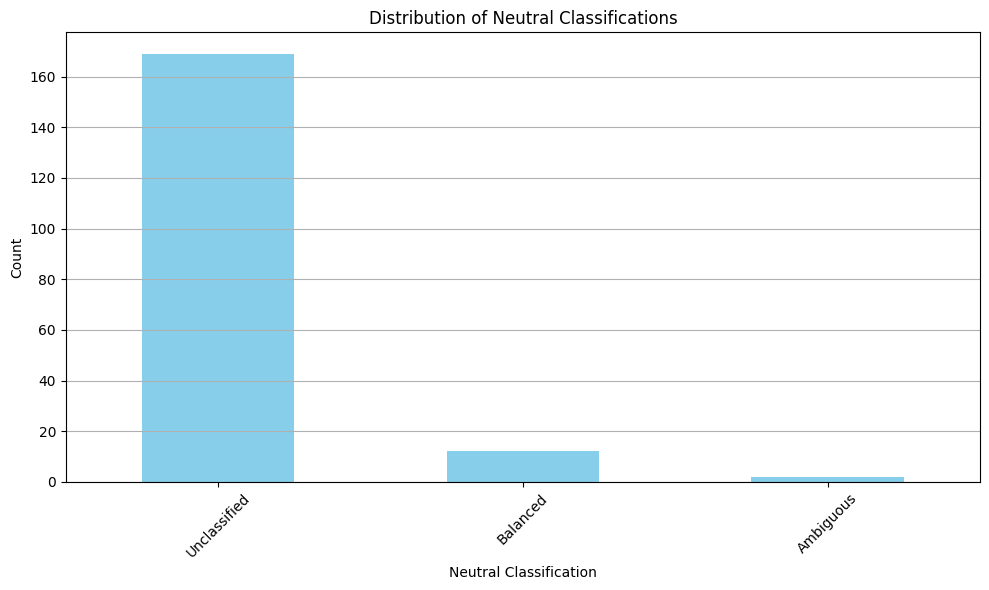

2025-01-03 14:53:02,725 - INFO - classify nuteral reviews plot completed


In [69]:
# Applying the classification function
df = process_reviews_for_classification(df)

# Plot Average Sentiment Scores
plot_neutral_classification_distribution(df)

As you can see this had little to no affect on the data. The next step is to use a LLM to process the data to see if that is able to better classify the data. 

In [70]:
# Set up the base URL and fetch data
base_url = 'https://uk.trustpilot.com/review/www.directline.com?page='
pages = 10
df_llm = fetch_reviews(base_url,pages)


# Data Preprocessing
df_llm['cleaned_notes'] = df_llm['Reviews'].apply(clean_text)
logger.info("All reviews successfully cleaned.")


2025-01-03 14:53:26,223 - INFO - Total reviews collected: 183
2025-01-03 14:53:27,356 - INFO - All reviews successfully cleaned.


In [71]:
load_dotenv()
# Set your API key
openai = OpenAI(
	api_key=os.environ.get("OPENAI_API_KEY")
)

In [72]:
# Function to handle the OpenAI completion request
def get_completion(prompt: str, model: str = "gpt-3.5-turbo", retries: int = 3, delay: int = 5) -> str:
    for attempt in range(1, retries + 1):
        try:
            messages = [{"role": "user", "content": prompt}]
            response = openai.chat.completions.create(
                model=model,
                messages=messages,
                temperature=0
            )
            return response.choices[0].message.content
        except APIConnectionError as e:
            logger.warning(f"API connection error on attempt {attempt}/{retries}: {e}")
            if attempt < retries:
                sleep(delay)
            else:
                logger.error(f"API connection failed after {retries} attempts.")
                raise
        except BaseException as e:
            logger.critical(f"Unexpected error: {e}")
            raise

In [73]:
def generate_prompt(batch_df: pd.DataFrame) -> str:
    """
    Generate a prompt for the OpenAI API based on the input DataFrame batch.

    Args:
        batch_df (pd.DataFrame): The current batch of data.

    Returns:
        str: A formatted prompt string.
    """
    return f"""
Perform sentiment analysis on the provided reviews and feedback data. For each review, classify the sentiment as 'positive', 'negative', or 'neutral'. 
Then select the key words from the 'Title' and 'cleaned_notes' based on their importance and relevance for summarisation or use in a word cloud.
These should be stored in the new column 'Key_Words' as a string.

Return the results as a JSON object with the following structure, including only these four fields for each review:
- Title: The title of the review.
- cleaned_notes: The full text of the review, cleaned as necessary for analysis.
- Sentiment_Classification: The classified sentiment ('positive', 'negative', or 'neutral').
- Key_Words: Key words extracted from the review as a string to assist in creating a word cloud.

Reviews: {batch_df.to_json(orient='records')}
"""

In [74]:
def process_in_batches(df: pd.DataFrame, batch_size: int = 10, model: str = "gpt-3.5-turbo") -> pd.DataFrame:
    """
    Process the DataFrame in batches to avoid token limitations.

    Args:
        df (pd.DataFrame): The input DataFrame to process.
        batch_size (int): Number of rows per batch.
        model (str): The model to use for completion.

    Returns:
        pd.DataFrame: A DataFrame with processed results combined.
    """
    total_batches = ceil(len(df) / batch_size)
    results = []

    logger.info(f"Starting batch processing. Total batches: {total_batches}.")

    for i in range(total_batches):
        logger.info(f"Processing batch {i + 1}/{total_batches}...")

        # Slice the DataFrame for the current batch
        batch_df = df.iloc[i * batch_size : (i + 1) * batch_size]

        # Prepare the prompt for the current batch
        prompt = generate_prompt(batch_df)

        # Call the API and process the response
        try:
            response = get_completion(prompt, model=model)
            batch_result = json.loads(response)

            if "reviews" in batch_result:
                results.extend(batch_result["reviews"])
                logger.info(f"Batch {i + 1}/{total_batches} processed successfully.")
            else:
                logger.error(f"Unexpected response format in batch {i + 1}: {batch_result}")

        except json.JSONDecodeError:
            logger.error(f"Error decoding JSON response in batch {i + 1}.")
        except Exception as e:
            logger.error(f"An error occurred in batch {i + 1}: {e}")

    # Check if results are empty
    if not results:
        logger.warning("No results were returned from the API.")
        return pd.DataFrame()  # Return an empty DataFrame

    # Convert the combined results to a DataFrame
    logger.info("Batch processing completed.")
    return pd.json_normalize(results)


In [75]:
# Process the DataFrame in batches, 20 reviews per page.
processed_df = process_in_batches(df_llm, batch_size=20, model="gpt-3.5-turbo")

# Show the first 5 rows of the processed DataFrame
processed_df.head(5)


2025-01-03 14:53:27,661 - INFO - Starting batch processing. Total batches: 10.
2025-01-03 14:53:27,661 - INFO - Processing batch 1/10...
2025-01-03 14:53:50,961 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-01-03 14:53:51,051 - INFO - Batch 1/10 processed successfully.
2025-01-03 14:53:51,051 - INFO - Processing batch 2/10...
2025-01-03 14:54:17,331 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-01-03 14:54:17,417 - INFO - Batch 2/10 processed successfully.
2025-01-03 14:54:17,417 - INFO - Processing batch 3/10...
2025-01-03 14:54:43,218 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-01-03 14:54:43,288 - INFO - Batch 3/10 processed successfully.
2025-01-03 14:54:43,288 - INFO - Processing batch 4/10...
2025-01-03 14:55:03,705 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-01-03 14:55:03,708 - INFO - 

,Title,cleaned_notes,Sentiment_Classification,Key_Words
0,Will never use another company!,fantastic company i renewed with dl in 2024 du...,positive,fantastic company renewed dl 2024 better price...
1,My claim was dealt with quickly and efficently,my claim was dealt with quickly and my car wen...,positive,claim dealt quickly car repair timely manner r...
2,Treated fairly I have,i have confidence that i will be treated fairl...,positive,confidence treated fairly many years insured o...
3,Superb company to deal with,direct line made a stressful situation totally...,positive,direct line made stressful situation stress fr...
4,Been with direct line for many many…,been with direct line for many many years alwa...,positive,direct line many years good quotes renewal qui...


Ensure that both DataFrames used by the LLM and NLTK model have the same number of reviews for a fair comparison; if they differ, truncate the larger DataFrame to match the smaller one, and verify that the reviews correspond correctly across both.

In [76]:
if len(processed_df) == len(df):
    print(f"Both DataFrames have the same number of reviews: {len(processed_df)} reviews.")
else:
    print(f"Warning: The DataFrames have a different number of reviews. LLM DataFrame has {len(processed_df)} reviews, NLTK DataFrame has {len(df)} reviews.")
      # Truncate the larger DataFrame to match the smaller one
    if len(processed_df) > len(df):
        processed_df = processed_df.head(len(df))
        print("LLM DataFrame has been truncated to match the NLTK DataFrame.")
    else:
        df = df.head(len(processed_df))
        print("NLTK DataFrame has been truncated to match the LLM DataFrame.")
    
    print("DataFrames have been aligned.")

# Strip whitespace and convert both columns to lowercase for comparison
processed_df['LLM_Title_cleaned'] = processed_df['Title'].str.lower().str.strip()
df['NLTK_Title_cleaned'] = df['Title'].str.lower().str.strip()

# Check if the cleaned titles are the same
if processed_df['LLM_Title_cleaned'].equals(df['NLTK_Title_cleaned']):
    print("The reviews in both DataFrames correspond to each other.")
else:
    print("Warning: The reviews do not match in both DataFrames.")

# Check for mismatches between the cleaned titles in processed_df and df
mismatch = processed_df[processed_df['LLM_Title_cleaned'] != df['NLTK_Title_cleaned']]

# Print out the first few mismatches from both DataFrames
mismatch_df = mismatch[['Title', 'LLM_Title_cleaned']].copy()
mismatch_df['NLTK_Title_cleaned'] = df.loc[mismatch.index, 'NLTK_Title_cleaned']

# Set pandas display options to show the full content of text columns
pd.set_option('display.max_colwidth', None)

# Display the mismatched rows with columns from both DataFrames
mismatch_df.head()



Both DataFrames have the same number of reviews: 183 reviews.


,Title,LLM_Title_cleaned,NLTK_Title_cleaned
16,I spoke to a real person and didnt…,i spoke to a real person and didnt…,i spoke to a real person and didn’t…
17,Im happy with Direct Line,im happy with direct line,i’m happy with direct line
63,good quote/ fair price/easy online...,good quote/ fair price/easy online...,good quote/ fair price/easy online…
65,Direct Line was great at looking after...,direct line was great at looking after...,direct line was great at looking after…
69,I was very happy with your staff..very...,i was very happy with your staff..very...,i was very happy with your staff..very…


## Visualisations using LLM Data
In this section, we will visualise the results from the LLM sentiment analysis. 

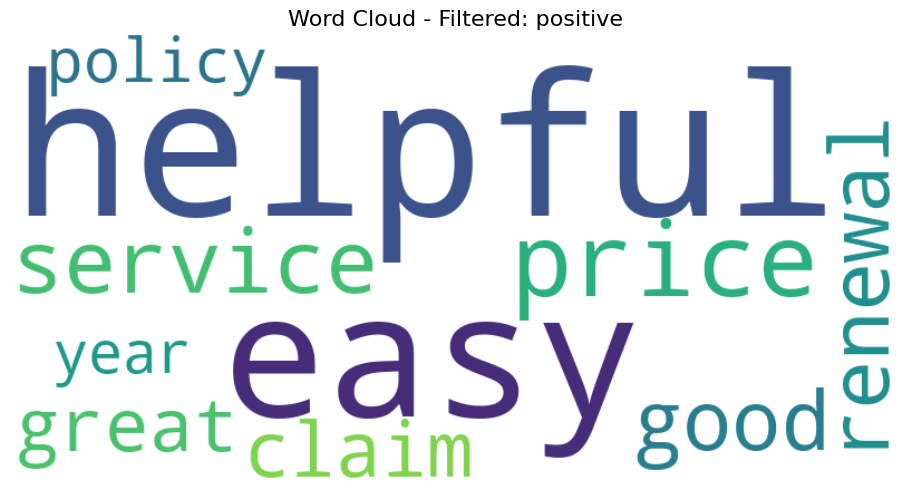

2025-01-03 14:56:46,473 - INFO - Word cloud successfully created.


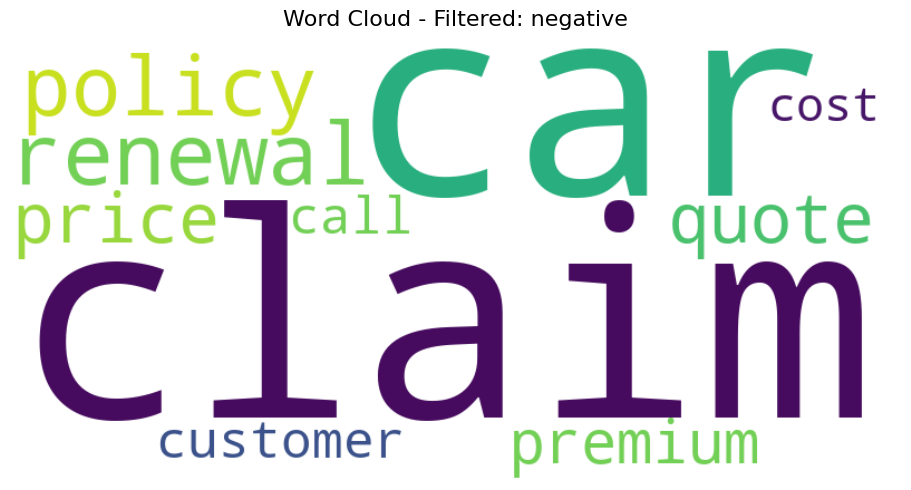

2025-01-03 14:56:46,704 - INFO - Word cloud successfully created.


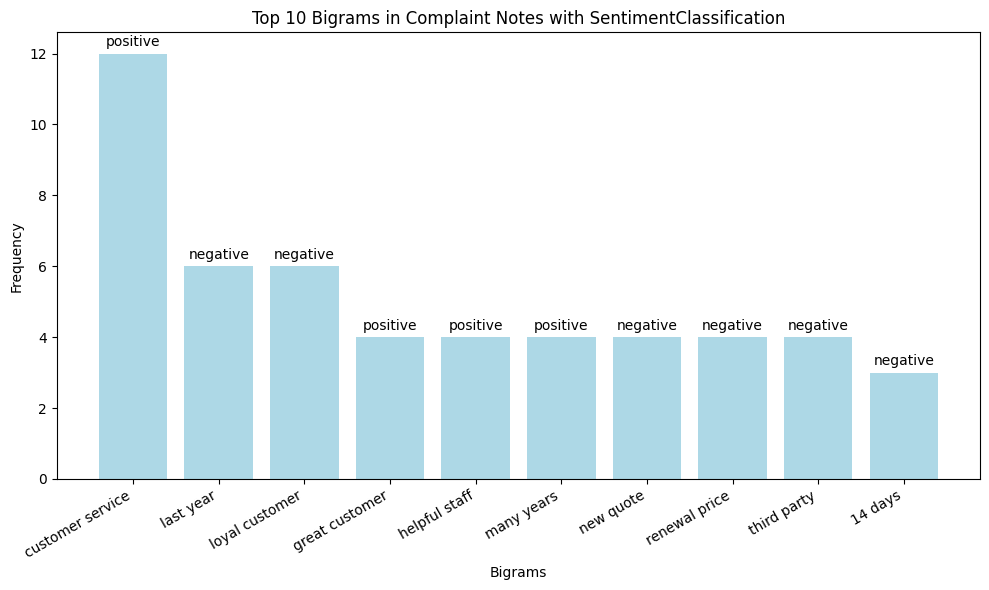

2025-01-03 14:56:46,831 - INFO - Bigrams with sentiment successfully created.


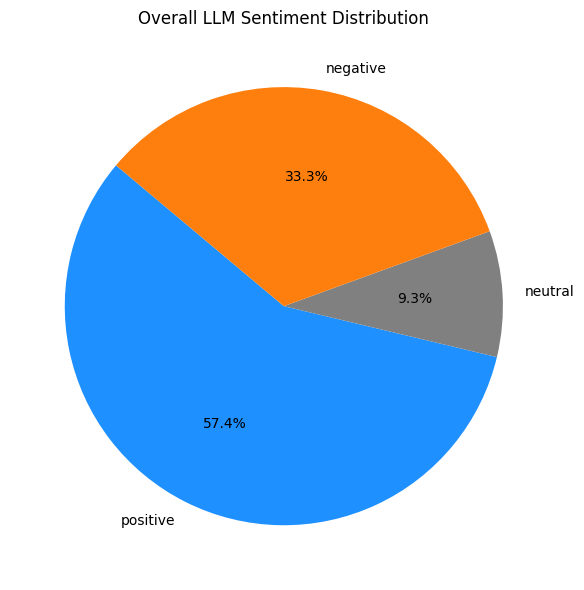

2025-01-03 14:56:46,873 - INFO - Oerall Sentiment distribution plot created


In [ ]:

# Generete wordcloud usinf key words identfied by the LLM.
generate_word_cloud(processed_df, num_words=10, sentiment_filter='positive', Sentiment_column = "Key_Words")
generate_word_cloud(processed_df, num_words=10, sentiment_filter='negative', Sentiment_column = "Key_Words")

top_n = 10
plot_common_bigrams_with_sentiment(processed_df, stop_words, top_n)

# Call the function to Overall Sentiment Distribution using the LLM df. 
plot_sentiment_distribution_overall(processed_df, sentiment_column='Sentiment_Classification', title='Overall LLM Sentiment Distribution')


In [81]:
# Set the filter word to use for the search
Filer_on = 'Renewal'
# Filter the DataFrame to extract rows where 'cleaned_notes' contains 'loyal customer'
df_filtered  = processed_df[processed_df['cleaned_notes'].str.contains(Filer_on, case=False, na=False)]

# Display the filtered DataFrame
df_filtered .head()

,Title,cleaned_notes,Sentiment_Classification,Key_Words,LLM_Title_cleaned
4,Been with direct line for many many…,been with direct line for many many years always good quotes on renewal quick and easy to renew online would highly recommend,positive,direct line many years good quotes renewal quick easy renew online highly recommend,been with direct line for many many…
12,Very disappointed,amazed by the lack of customer service i have just received rang to question why my insurance has increased by 44 compared to last year i also stated that by going on a comparison site i actually got quotes from reputable insurers which were actually less than i paid last year the agent i spoke to asked me three times about the level of cover to which i replied that the quotes i had in front of me were for equivalent cover she then started to ask me questions about the level of cover and i stated again that it was for equivalent cover at no point did she say that she would take a look at my renewal and see if it was correct or make any attempt to keep me as a customer i asked for automatic renewal to be removed i have previously stayed loyal when the price difference was marginal but no way am i paying 44 more when i can get the same level of cover for less that my last years premium,negative,lack customer service received question insurance increased 44 comparison site got quotes reputable insurers less paid agent spoke three times level cover replied quotes front equivalent cover started questions point take look renewal correct attempt keep customer asked automatic renewal removed previously stayed loyal price difference marginal paying 44 level cover less last years premium,very disappointed
15,Don’t waste your time!,after the insulting car insurance renewal last time i vowed i wouldnt bother putting my details into org site again but being the value hunter i am i gave it one last try home insurance quote for a low risk street in a low risk town with a policy holder who has never made a claim on any home insurance policy in his life came back as more than double what other major firms were quoting how are direct line still in business dont waste your time folks theyre a joke,negative,insulting car insurance renewal vowed bother putting details site value hunter gave try home insurance quote low risk street low risk town policy holder never made claim home insurance policy life came double major firms quoting direct line still business waste time folks joke,don’t waste your time!
17,Im happy with Direct Line,im happy with org find their people helpful and their website easy to use i just wish that their renewal quotes were their best number not an inflated one that they seem happy to reduce when you call and say what their competitors are offering,positive,happy org people helpful website easy use wish renewal quotes best number inflated seem reduce call say competitors offering,im happy with direct line
18,Car Insurance renewalI,i called to speak about car insurance renewal person was extremely helpful she was able to offer me a price that i was happy with she was well informed and gave me good advice about your policies i would certainly recommend direct line,positive,called speak car insurance renewal person extremely helpful offer price happy well informed gave good advice policies certainly recommend direct line,car insurance renewali


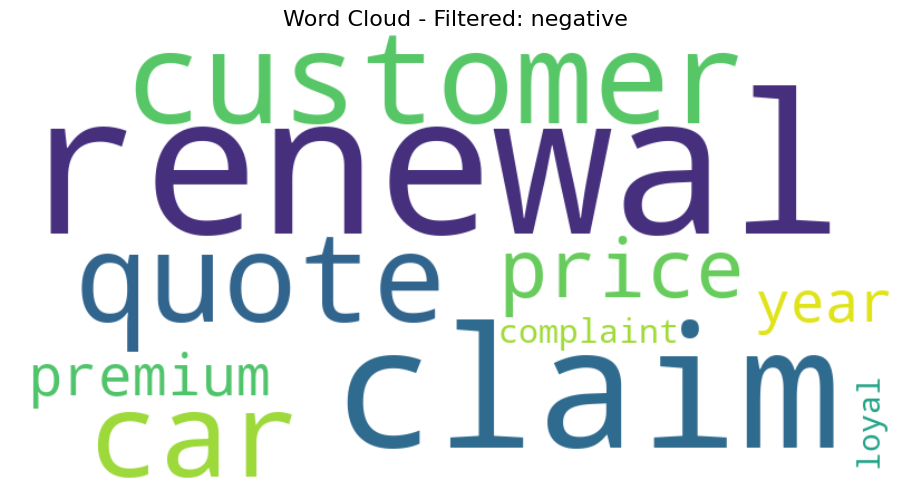

2025-01-03 15:02:05,614 - INFO - Word cloud successfully created.


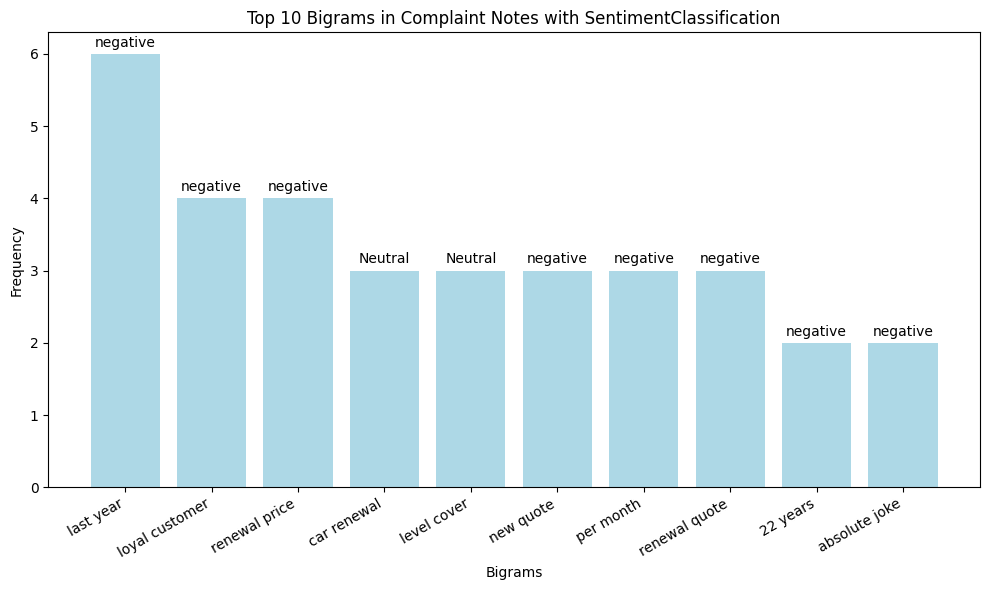

2025-01-03 15:02:05,736 - INFO - Bigrams with sentiment successfully created.


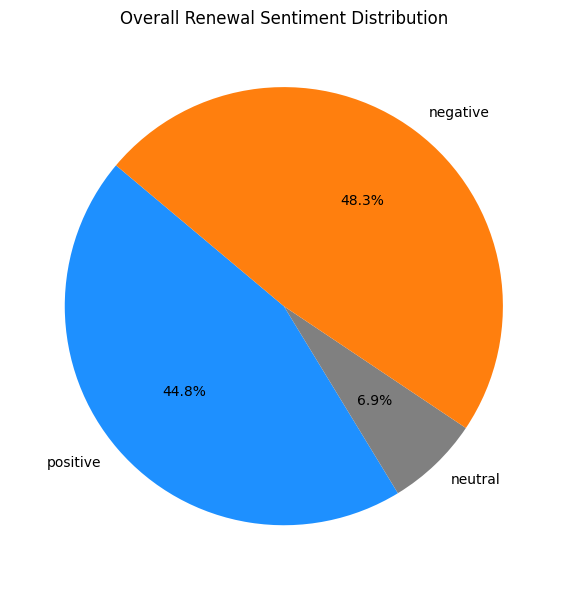

2025-01-03 15:02:05,782 - INFO - Oerall Sentiment distribution plot created


In [82]:
# Generete wordcloud usinf key words identfied by the LLM.
generate_word_cloud(df_filtered , num_words=10, sentiment_filter='negative', Sentiment_column = "Key_Words")
top_n = 10
plot_common_bigrams_with_sentiment(df_filtered , stop_words, top_n)

# Call the function to Overall Sentiment Distribution using the LLM df. 
plot_sentiment_distribution_overall(df_filtered , sentiment_column='Sentiment_Classification', title='Overall Renewal Sentiment Distribution')